# Creating a model predicting number of passenger deaths based on flights  in 80s

In [1]:
import sys
import pystan
import stan_utility

import arviz as az
import numpy as np
import scipy.stats as stats
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl

light="#FFFCDC"
light_highlight="#FEF590"
mid="#FDED2A"
mid_highlight="#f0dc05"
dark="#EECA02"
dark_highlight="#BB9700"
green="#00FF00"
light_grey="#DDDDDD"

plt.style.context('seaborn-white')
mpl.rcParams['figure.dpi']= 200

In [3]:
dts=[24,734,25,516,31,754,31,877,22,814,21,362,26,764,20,809,16,223,22,1066]
c1=dts[::2]
c2=dts[1::2]

Airline_data=pd.DataFrame({'Year':[1976,1977,1978,1979,1980,1981,1982,1983,1984,1985],
'Fatal accidents':c1,  
'Passenger deaths':c2,
'Death rate':[0.19,0.12,0.15,0.16,0.14,0.06,0.13,0.13,0.03,0.15]}).set_index('Year')
Airline_data['Miles flown [100 mln miles]']=np.round(Airline_data['Passenger deaths']/Airline_data['Death rate'])

## generation of vector for plotting samples under histograms
acc=[]
dta_cnt=[]
for k in Airline_data['Fatal accidents']:  
    dta_cnt.append(-(1.+acc.count(k)))
    acc.append(k)
dta_cnt=np.array(dta_cnt)

Airline_data

,Fatal accidents,Passenger deaths,Death rate,Miles flown [100 mln miles]
Year,,,,
1976,24,734,0.19,3863.0
1977,25,516,0.12,4300.0
1978,31,754,0.15,5027.0
1979,31,877,0.16,5481.0
1980,22,814,0.14,5814.0
1981,21,362,0.06,6033.0
1982,26,764,0.13,5877.0
1983,20,809,0.13,6223.0
1984,16,223,0.03,7433.0


## 1. The rate is constant for all years and not depending on anything.

## Model for accidents

I start modelling by proposing very simple model, with an assumption, that Fatal accidents number $y_i$ has a Poisson distribution 
$$y_i\sim\mathrm{Poisson}(\lambda)$$
with a rate $\lambda$ independent on year or miles flown.

### Prior for fatal accidents rate
Number of passengers death are very varied, in '84, 223 deaths, and in '85, 1066 deaths, so I define prior probability by normal distribution, where 90% values are between this range. It's not a really good assumption, but due to lack of knowledge, I need to start with something.



In [4]:
with open('prior_tune.stan', 'r') as file:
    print(file.read())

functions {
  vector tail_delta(vector y,       //unknowns
                    vector theta,   //parameters
                    real[] x_r,     // data(real)
                    int[] x_i) {    //data(integer)
    vector[2] deltas;

    deltas[1] = normal_cdf(theta[1], y[1], y[2]) - 0.95; //5% that more than 1066 deaths
    deltas[2] = normal_cdf(theta[2], y[1], y[2]) - 0.05; //5% that less than 223 deaths
    return deltas;
  }
}

data {
  vector<lower=0>[2] y_guess; // Initial guess of Gaussian standard deviation
  vector<lower=0>[2] theta;   // Target quantile
}

transformed data {
  vector[2] y;
  real x_r[0];
  int x_i[0];

  // Find gamma parameters that ensures 90% probabilty from 223 to 1066
  y = algebra_solver(tail_delta, y_guess, theta, x_r, x_i);
  print("mu  = ", y[1]);
  print("sigma = ", y[2]);
}

generated quantities {
  real mu = y[1];
  real sigma = y[2];
}



In [5]:
tuning = stan_utility.compile_model('prior_tune.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_753a3aff464a2c025237141c1b088187 NOW.


In [6]:
data=dict(y_guess=np.array([670,200]),theta=np.array([1066,223]))
tuned = tuning.sampling(data=data,
                          seed=1052020,
                          algorithm="Fixed_param",
                          iter=1, 
                          warmup=0,
                          chains=1)
mu = np.round(tuned.extract()['mu'][0])
sigma = np.round(tuned.extract()['sigma'][0])

print(mu,sigma)

644.0 256.0


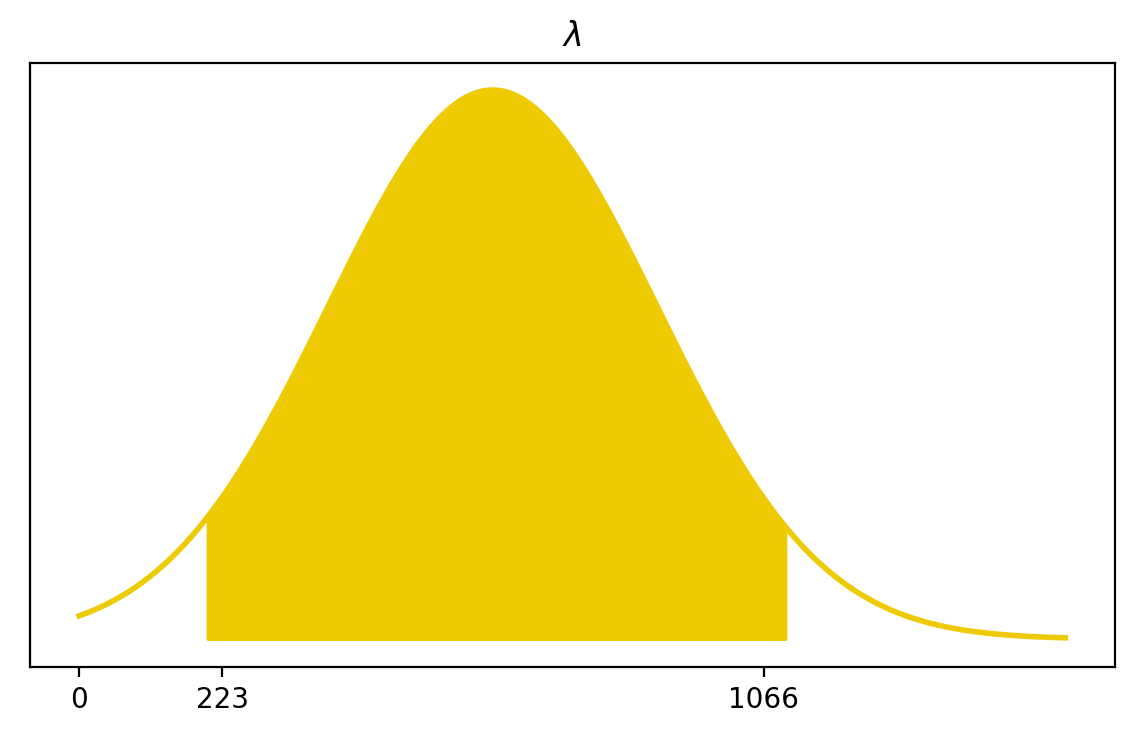

In [7]:
fig, ax2 = plt.subplots(1, 1,figsize=(7, 4))
x2=np.linspace(0,6*sigma,1000)
x4=np.linspace(200,1100,1000)
ax2.plot(x2,stats.norm.pdf(x2,loc=mu,scale=sigma),color=dark,linewidth=2)
ax2.fill_between(x4,stats.norm.pdf(x4,loc=mu,scale=sigma),0,color=dark)
ax2.set_yticks([])
ax2.set_xticks([0,223,1066])
ax2.set_title(r'$\lambda$')
plt.show()

### Prior predictive distribution
Simulation possible outputs and parameteres based only on prior information.

In [8]:
with open('airline_FA_norm_ppc.stan', 'r') as file:
    print(file.read())

data {
  int M;//number of years analyzed
}


generated quantities {
  real lambda=normal_rng(650,274);
  int y_sim[M];
  for (k in 1:M) {
    y_sim[k] = poisson_rng(lambda);
  }
}



In [9]:
model_prior=stan_utility.compile_model('airline_FA_norm_ppc.stan')

Using cached StanModel


In [10]:
R=1000
sim_uf=model_prior.sampling(data={'M':1},
                            algorithm="Fixed_param",
                            iter=R,
                            warmup=0,
                            chains=1, 
                            refresh=R,
                            seed=29042020)

/home/adrian/anaconda3/envs/stan_env/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/adrian/anaconda3/envs/stan_env/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/home/adrian/anaconda3/envs/stan_env/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/adrian/anaconda3/envs/stan_env/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


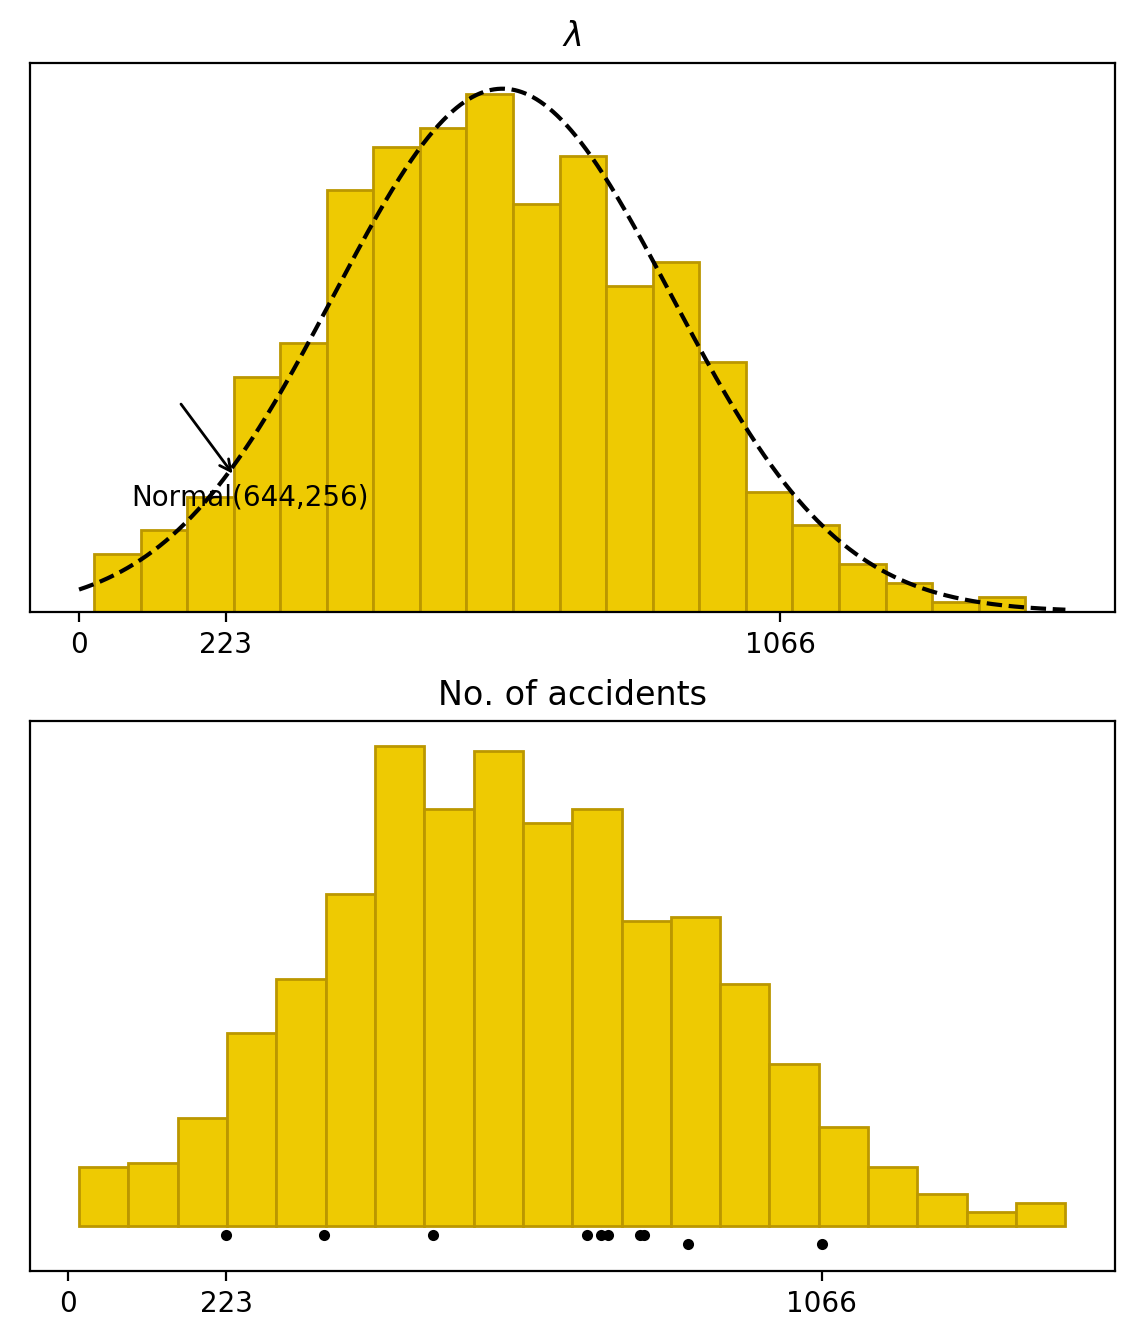

In [11]:
params=sim_uf.extract()
theta=params['lambda']
y_sim=params['y_sim']

fig, axes = plt.subplots(2, 1,figsize=(7, 8))
ax1=axes[0]
ax1.hist(theta,bins=20,color=dark,edgecolor=dark_highlight,density=True)
x=np.linspace(0,1500,2000)
ax1.set_xticks([0,223,1066])
ax1.set_yticks([])
ax1.set_title(r'$\lambda$')
ax1.plot(x,stats.norm.pdf(x,mu,sigma),color='black',linestyle='--')
arr_y_loc = stats.norm.pdf(300,mu,sigma)
ax1.annotate('Normal('+str(np.int(mu))+','+str(np.int(sigma))+')',xy=(150,arr_y_loc),xytext=(80,0.5*arr_y_loc),arrowprops={'arrowstyle':'<-'})
ax2=axes[1]
ax2.hist(y_sim.flatten(),color=dark,edgecolor=dark_highlight,density=True,bins=20,zorder=1)
ax2.scatter(c2,0.00003*dta_cnt,color='black',marker='.',zorder=2)
ax2.set_xticks([0,223,1066])
ax2.set_yticks([])

ax2.set_title('No. of accidents')
plt.show()

Created prior is not the best one, but technically it's okay. Due to lack of information, it is hard to create accurate prior.

### Posterior inference and posterior predictive checks

In [12]:
with open('airline_FA_norm_fit.stan', 'r') as file:
    print(file.read())

data {
  int M;//number of years analyzed
  int y[M];//number of deaths
}
parameters {
  real<lower=0>lambda;
}
model {
  lambda ~ normal(644,256);
  for (k in 1:M) {
    y[k] ~ poisson(lambda);
  }
}
generated quantities {
  int y_sim[M];
  for (k in 1:M) {
    y_sim[k] = poisson_rng(lambda);
  }
}



In [13]:
model=stan_utility.compile_model('airline_FA_norm_fit.stan')

Using cached StanModel


In [14]:
data = dict(M = len(Airline_data),
            y = Airline_data['Passenger deaths'])
fit = model.sampling(data=data, seed=8052020)

params=fit.extract()
lam=params['lambda']
y_sim=params['y_sim']

In [15]:
mean_lam = np.mean(lam)
cinf_lam = az.hpd(lam,0.89)

hpd_width=cinf_lam[1]-cinf_lam[0]

In [16]:
print('Mean lambda : {:4.2f}'.format(mean_lam))
print('89% confidence interval: [',*['{:4.2f}'.format(k) for k in cinf_lam],']')

Mean lambda : 691.92
89% confidence interval: [ 679.09 705.24 ]


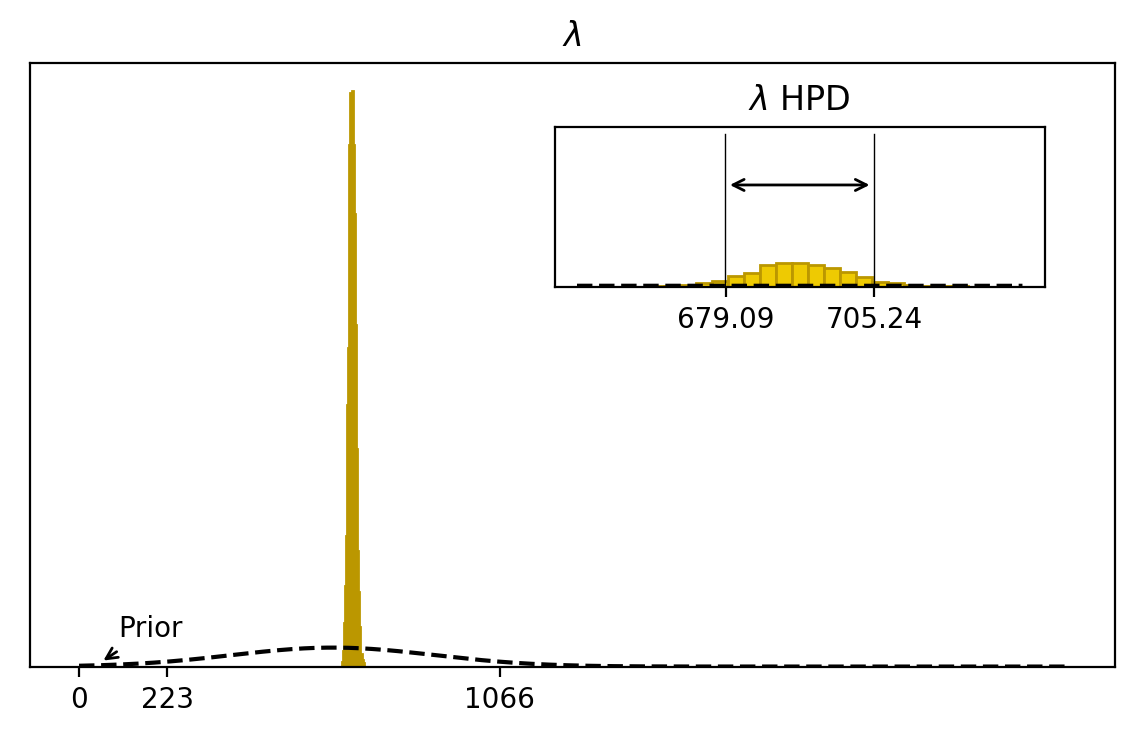

In [17]:
fig, ax1 = plt.subplots(1, 1,figsize=(7, 4))

ax1.hist(lam,bins=20,color=dark,edgecolor=dark_highlight,density=True)
x=np.linspace(0,2500,10000)
#ax1.plot(x,2*stats.t.pdf(x,5,0,10),color='black',linestyle='--')

ax1.plot(x,stats.norm.pdf(x,mu,sigma),color='black',linestyle='--')
arr_y_loc = stats.norm.pdf(150,mu,sigma)
ax1.annotate('Prior',xy=(50,arr_y_loc),xytext=(100,10*arr_y_loc),arrowprops={'arrowstyle':'->'})
ax1.set_xticks([0,223,1066])

ax1.set_yticks([])
ax1.set_title(r'$\lambda$')

ax_sm=plt.axes([0.5,0.6,0.35,0.2])
x_sm=np.linspace(cinf_lam[0]-hpd_width,cinf_lam[1]+hpd_width,200)
ax_sm.hist(lam,bins=20,color=dark,edgecolor=dark_highlight,density=True)
ax_sm.plot(x_sm,stats.norm.pdf(x_sm,mu,sigma),color='black',linestyle='--')
ax_sm.annotate(s='', xy=(cinf_lam[0]-.2,0.2), xytext=(cinf_lam[1]+.2,0.2), arrowprops=dict(arrowstyle='<->'))
ax_sm.plot([cinf_lam[0],cinf_lam[0]],[0,0.3],color='black',linestyle='-',linewidth=0.5)
ax_sm.plot([cinf_lam[1],cinf_lam[1]],[0,0.3],color='black',linestyle='-',linewidth=0.5)

ax_sm.set_xticks(np.round([cinf_lam[0],cinf_lam[1]],2))
ax_sm.set_yticks([])
ax_sm.set_title(r'$\lambda$ HPD')

plt.show()

## Using created model for prediction

In [18]:
median_y_sim = np.median(y_sim.flatten())
cinf_y_sim = az.hpd(y_sim.flatten(),0.89)

print('Median of predicted accidents =',median_y_sim)
print('Confidence interval = [',*cinf_y_sim,']')

Median of predicted accidents = 692.0
Confidence interval = [ 645.0 733.0 ]


In 1986, there were **546** passenger deaths, but prediction based on created model is equal **692**. This means that created model don't work correctly, beacuse real value of passenger deaths is not in between cofidence intervals.

Such a bad result is cause, because lack of information on the system. Created model was creadted ony based on deaths over the years, but there is much more thing that can affect on results e. g, number of flights, distance and so on.

## 2. The intensity is constant, but rate is a product of intensity and miles flown.